In [51]:
%matplotlib inline
 
import numpy as np
import pandas as pd
import sklearn as sk
 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

We begin with reading in our data and doing some initial cleaning.

In [12]:
# Read in data
data = pd.read_csv('data.csv')

# Filter out new data
data_current = data[data.year >= 2010]

# Remove duplicate values based on id
data_current = data_current.drop_duplicates(subset=['id'],keep='first',inplace=False)
data_current.shape # shape matches what we have in R; we're good here.

(26711, 19)

In [17]:
# Creating a new popularity dummy variable
def groups(series):
    if 75 <= series <= 100:
        return 3
    elif 50 <= series < 75:
        return 2
    elif 25 <= series < 50:
        return 1
    elif series < 25:
        return 0
data_current['popDummy'] = data_current['popularity'].apply(groups)

# Converting duration_ms to seconds
data_current['duration_s'] = data_current['duration_ms']*.001

# Recoding year variable
def groups(series):
    if series == 2010:
        return 0
    elif series == 2011:
        return 1
    elif series == 2012:
        return 2
    elif series == 2013:
        return 3
    elif series == 2014:
        return 4
    elif series == 2015:
        return 5
    elif series == 2016:
        return 6
    elif series == 2017:
        return 7
    elif series == 2018:
        return 8
    elif series == 2019:
        return 9
    elif series == 2020:
        return 10
    elif series == 2021:
        return 11
data_current['year_factor'] = data_current['year'].apply(groups)

data_current.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,name,popularity,release_date,speechiness,tempo,valence,year,popDummy,duration_s,year_factor
9087,0.887,['Frank Sinatra'],0.319,187333,0.201,0,1hx7X9cMXHWJjknb9O6Ava,0.000000,7,0.9040,...,The September Of My Years - Live At The Sands ...,27,2018-05-04,0.0623,117.153,0.239,2018,1,187.333,8
9091,0.938,['Frank Sinatra'],0.269,236800,0.129,0,19oquvXf3bc65GSqtPYA5S,0.000005,7,0.6830,...,It Was A Very Good Year - Live At The Sands Ho...,26,2018-05-04,0.0576,82.332,0.160,2018,1,236.800,8
9111,0.881,['Joni Mitchell'],0.644,313093,0.212,0,55qyghODi24yaDgKBI6lx0,0.000022,11,0.7980,...,"The Circle Game - Live at The 2nd Fret, Philad...",19,2020-10-30,0.0347,117.072,0.441,2020,0,313.093,10
9117,0.955,['Joni Mitchell'],0.627,295093,0.184,0,00xemFYjQNRpOlPhVaLAHa,0.000162,1,0.0986,...,"Urge For Going - Live at The 2nd Fret, Philade...",19,2020-10-30,0.0450,115.864,0.299,2020,0,295.093,10
9119,0.888,['Joni Mitchell'],0.581,183440,0.331,0,2lm5FQJRHvc3rUN5YHpEWj,0.000015,6,0.1470,...,What's The Story Mr. Blue - Live at The 2nd Fr...,19,2020-10-30,0.2430,88.303,0.642,2020,0,183.440,10


In [19]:
# Subsetting our data to use for model--let's call this 'spotify'
spotify = data_current[['popDummy','instrumentalness','explicit','loudness','duration_s','liveness','year_factor']]

# We're going to only use data from 2010-2021, and predict 2021.
spotify_new = spotify[spotify.year_factor == 11]
spotify = spotify[spotify.year_factor < 11]

# Just a quick look-through to make sure the data is good
print(spotify.head())

      popDummy  instrumentalness  explicit  loudness  duration_s  liveness  \
9087         1          0.000000         0   -17.796     187.333    0.9040   
9091         1          0.000005         0   -18.168     236.800    0.6830   
9111         0          0.000022         0   -14.118     313.093    0.7980   
9117         0          0.000162         0   -15.533     295.093    0.0986   
9119         0          0.000015         0   -14.087     183.440    0.1470   

      year_factor  
9087            8  
9091            8  
9111           10  
9117           10  
9119           10  


In [8]:
print(list(spotify.columns))

['popDummy', 'instrumentalness', 'explicit', 'loudness', 'duration_s', 'liveness', 'year_factor']


In [9]:
print(spotify.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25318 entries, 9087 to 174188
Data columns (total 7 columns):
popDummy            25318 non-null int64
instrumentalness    25318 non-null float64
explicit            25318 non-null int64
loudness            25318 non-null float64
duration_s          25318 non-null float64
liveness            25318 non-null float64
year_factor         25318 non-null int64
dtypes: float64(4), int64(3)
memory usage: 1.5 MB
None


Things to consider:
    - change instrumentalness variable to factor?
    - ensure explicit, key, mode, and year are factors

MODEL SELECTION

In [20]:
train, test = train_test_split(spotify, test_size = 0.2, random_state = 123)

# Creating dataframes for the training/test inputs/target
train_X = train.drop(['popDummy'], axis=1)
train_Y = train["popDummy"]
test_X = test.drop(['popDummy'], axis=1)
test_Y = test["popDummy"]

test_Y.size

5064

In [21]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20254 entries, 75235 to 142971
Data columns (total 6 columns):
instrumentalness    20254 non-null float64
explicit            20254 non-null int64
loudness            20254 non-null float64
duration_s          20254 non-null float64
liveness            20254 non-null float64
year_factor         20254 non-null int64
dtypes: float64(4), int64(2)
memory usage: 1.1 MB


1. Multinomial logisitic regression

In [24]:
# Declare model
lr_model = LogisticRegression()

# Fitting model on training data
lr_model.fit(train_X,train_Y)

# Printing our our predicted values
Y_hat = lr_model.predict(test_X)
with np.printoptions(threshold=np.inf):
    print(Y_hat)

[0 2 0 2 0 0 0 0 2 0 0 0 2 2 0 0 2 0 0 2 0 2 2 0 0 0 0 0 2 0 2 0 2 0 2 2 0
 0 2 2 0 0 3 0 0 2 0 0 0 0 2 2 0 0 0 0 0 0 0 0 2 0 2 0 0 2 2 0 0 0 0 0 2 0
 0 2 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 2 0 0 2 2 0 2 0 0 0 0 0 2 2 0 0
 0 2 0 0 0 2 0 0 0 3 0 0 0 0 2 2 0 2 0 2 0 0 0 0 0 0 2 2 0 2 0 0 0 0 0 0 0
 2 2 2 0 2 0 0 0 0 0 2 0 2 0 0 0 0 2 0 2 0 0 2 2 0 0 2 0 0 2 2 2 0 3 0 2 3
 0 0 2 0 0 0 2 2 0 0 0 2 2 0 0 0 2 2 2 0 0 0 0 0 2 0 0 2 0 0 2 0 2 0 2 0 2
 2 2 0 0 0 0 0 2 0 2 0 0 2 2 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 2 2 0 0
 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 2 0 2 2 0 0 0 0 2 0 2 0 2
 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 0 0 0 0 0 2 2 2 0 0 0 0 2
 2 2 0 0 2 0 2 0 0 0 0 2 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 2 0 0 2 0 0 2 0 0 2
 0 0 0 3 2 2 0 2 2 0 3 0 0 2 0 3 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 2
 0 2 0 0 0 0 0 2 0 2 2 0 0 0 0 0 0 0 2 0 2 0 2 0 0 2 2 2 0 0 0 2 2 0 0 2 2
 2 0 2 0 3 3 0 0 0 0 0 2 

/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [25]:
# confusion matrix
conf_matrix = confusion_matrix(test_Y,Y_hat)
print(conf_matrix)

[[2455   11  330   29]
 [ 104    0   63    3]
 [ 834    1  933   22]
 [ 151    0  108   20]]


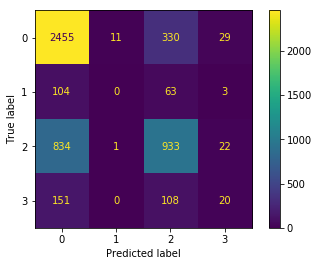

In [52]:
plot_confusion_matrix(lr_model, test_X, test_Y)

In [26]:
# classification report
print(classification_report(Y_hat,test_Y))
# warning; most likely due to all predictions being 0

              precision    recall  f1-score   support

           0       0.87      0.69      0.77      3544
           1       0.00      0.00      0.00        12
           2       0.52      0.65      0.58      1434
           3       0.07      0.27      0.11        74

    accuracy                           0.67      5064
   macro avg       0.37      0.40      0.37      5064
weighted avg       0.76      0.67      0.71      5064



In [27]:
# accuracy measure
print(accuracy_score(Y_hat,test_Y))

0.6729857819905213


2. kNN 

In [29]:
# First find the optimal # of neighbors
scores = []
for i in range(1, 30):
    knn_model = KNeighborsClassifier(n_neighbors = i)
    knn_model.fit(train_X, train_Y)
    y_model = knn_model.predict(test_X)
    scores.append(accuracy_score(test_Y, y_model))
    
max_val = max(scores)
print(max_val, scores.index(max_val))

0.6773301737756714 9


In [31]:
k = scores.index(max_val)

# Create model object
knn_model = KNeighborsClassifier(k)

# Train model
knn_model.fit(train_X, train_Y)

# Test model
Y_hat = knn_model.predict(test_X)

# Printing our our predicted values
with np.printoptions(threshold=np.inf):
    print(Y_hat)

[0 0 0 2 2 2 0 2 2 0 0 0 0 0 0 2 2 0 0 2 0 2 2 2 0 2 0 2 0 2 2 0 0 0 2 2 2
 0 2 2 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 2 2 0 0 0 0 0 2 0 2 0 2 0 0 2 0 2 0
 3 2 0 0 0 2 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 2 2 0 0
 0 2 0 0 0 0 0 0 2 0 0 2 0 0 0 2 0 0 2 2 2 0 0 0 0 0 2 2 0 2 0 0 0 0 0 0 0
 2 0 2 2 2 2 0 2 0 0 2 0 3 0 0 0 0 2 2 2 0 0 2 2 0 2 2 0 0 2 0 2 0 0 0 0 0
 2 2 2 0 0 0 2 2 0 2 2 0 2 0 0 0 0 2 2 0 0 0 0 2 2 2 0 0 0 0 2 0 2 2 0 0 2
 2 2 2 0 2 0 0 0 0 2 2 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 2 0 2 2 0 0 0 2
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 2 2 2
 0 0 0 0 0 2 0 2 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 2 2 2 0 0 2 2 0 2 0 0
 0 0 2 0 1 0 2 0 0 0 0 0 2 2 2 2 0 0 2 0 0 2 2 0 2 0 0 2 0 2 0 2 0 2 0 2 2
 0 0 2 2 2 0 2 2 0 0 0 2 0 2 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 2
 0 2 0 0 0 2 0 0 2 0 0 0 0 3 0 2 0 0 0 0 0 0 3 0 0 2 0 0 0 2 0 0 0 2 0 2 2
 2 0 0 0 0 0 0 0 0 2 2 0 2 0 0 2 0 0 2 0 2 0 2 2 0 2 0 2 0 0 0 2 2 0 0 2 0
 0 2 2 0 0 0 0 0 0 2 0 0 

In [32]:
# confusion matrix
conf_matrix = confusion_matrix(test_Y, Y_hat)
print(conf_matrix)

[[2271    4  517   33]
 [  93   15   60    2]
 [ 682    3 1078   27]
 [ 142    0  113   24]]


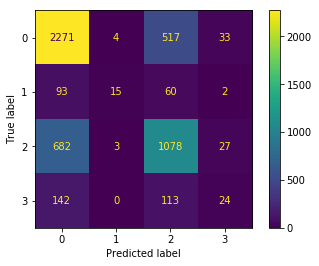

In [53]:
plot_confusion_matrix(knn_model, test_X, test_Y)

In [33]:
# classification report
print(classification_report(test_Y, Y_hat))

              precision    recall  f1-score   support

           0       0.71      0.80      0.76      2825
           1       0.68      0.09      0.16       170
           2       0.61      0.60      0.61      1790
           3       0.28      0.09      0.13       279

    accuracy                           0.67      5064
   macro avg       0.57      0.40      0.41      5064
weighted avg       0.65      0.67      0.65      5064



In [34]:
# accuracy measure
print("Accuracy: ", accuracy_score(test_Y,Y_hat))

Accuracy:  0.6690363349131122


3. Classification tree

In [35]:
# Create model object
tree_model = DecisionTreeClassifier()

# Train model
tree_model.fit(train_X, train_Y)

# Test model
Y_hat = tree_model.predict(test_X)

# Printing our our predicted values
with np.printoptions(threshold=np.inf):
    print(Y_hat)

[2 0 0 2 0 2 0 0 3 0 2 0 2 2 0 0 0 1 0 2 2 1 2 2 0 0 0 1 2 2 2 0 0 0 2 0 2
 0 2 0 0 0 2 0 3 2 0 0 0 0 0 2 0 0 0 0 2 0 0 2 1 0 0 0 0 2 2 2 0 0 0 0 2 0
 2 2 0 0 0 2 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 2 0 2 2 3 3 3 0 0 1 0 2 2 0 0
 0 2 0 0 0 3 3 0 2 3 0 0 0 3 0 2 0 0 3 2 2 3 2 0 0 0 2 2 0 2 0 0 0 2 2 0 0
 2 2 2 2 2 2 0 2 0 0 2 0 0 0 0 0 0 0 2 2 0 0 2 2 0 0 2 0 0 2 0 2 1 2 0 2 0
 2 2 2 3 0 1 2 2 1 2 0 2 0 0 0 3 0 0 2 1 0 0 1 2 2 2 0 2 0 2 2 0 2 2 2 0 2
 2 2 2 0 3 0 0 2 0 2 2 0 2 0 0 2 0 2 0 0 0 0 0 0 0 2 3 0 0 0 0 0 2 2 2 0 0
 0 2 0 2 3 0 0 0 0 0 0 0 2 0 0 0 1 0 2 0 2 2 0 0 2 0 0 0 0 3 0 0 0 0 0 3 0
 0 0 0 0 2 2 0 2 0 0 0 3 0 0 0 0 2 2 0 3 2 2 0 2 2 0 2 2 0 0 0 2 2 0 2 2 0
 2 0 0 0 0 0 2 0 0 2 0 0 2 0 2 0 2 0 2 0 3 3 0 2 2 2 0 3 0 2 0 3 2 1 0 2 2
 0 0 1 2 2 0 2 0 0 0 0 3 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 2 0 0 2 0 0 2 2 0 2
 2 0 0 3 0 3 0 2 0 0 0 0 0 3 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0
 0 2 0 0 0 0 3 0 0 2 2 2 3 2 0 2 3 0 2 0 2 3 2 0 0 2 2 2 2 0 0 2 2 0 0 2 2
 2 2 0 0 2 0 0 0 0 0 0 0 

In [36]:
# confusion matrix
conf_matrix = confusion_matrix(test_Y, Y_hat)
print(conf_matrix)

[[2125   88  510  102]
 [  77   30   57    6]
 [ 480   53 1113  144]
 [  77   12  136   54]]


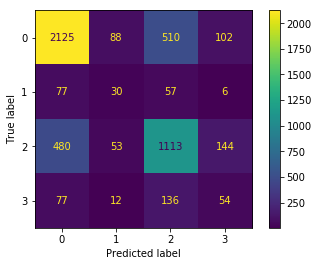

In [54]:
plot_confusion_matrix(tree_model, test_X, test_Y)

In [37]:
# classification report
print(classification_report(test_Y, Y_hat))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2825
           1       0.16      0.18      0.17       170
           2       0.61      0.62      0.62      1790
           3       0.18      0.19      0.18       279

    accuracy                           0.66      5064
   macro avg       0.43      0.44      0.43      5064
weighted avg       0.66      0.66      0.66      5064



In [38]:
# accuracy measure
print("Accuracy: ", accuracy_score(test_Y,Y_hat))

Accuracy:  0.656003159557662


Testing our models on 2021 data:

In [39]:
X = spotify_new.drop(['popDummy'], axis=1)
Y = spotify_new['popDummy']

# Logistic regression
# Printing our our predicted values
Y_hat = lr_model.predict(X)
with np.printoptions(threshold=np.inf):
    print(Y_hat)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 3 0 0 3 0 3 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2 3 0 2 0 3
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 2 3 0 3 0 2 0 2 2 0 3 3 0 3 3 2 0 0 0 3 0
 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 3 3 0 3 0 0 0 3
 3 0 0 3 0 3 0 0 0 3 0 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 3 0 3 0 0 0 0 0 3 0 3 0 0 3 0 0 0 0 0 3 0 3 3 0 0 0 0 0 3 3 0 0
 3 0 0 0 0 0 0 0 0 0 3 3 3 3 0 3 0 3 0 3 0 0 3 0 0 0 0 0 0 3 3 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 3 3 0 0 3 3
 0 2 3 3 3 3 0 3 0 0 0 3 3 3 3 3 0 0 3 3 3 0 3 3 0 3 3 3 0 0 0 0 3 3 3 3 0
 3 0 0 0 2 0 0 0 0 0 2 0 

In [40]:
# confusion matrix
conf_matrix = confusion_matrix(Y, Y_hat)
print(conf_matrix)

[[890   0  81 221]
 [ 36   0   3  16]
 [ 71   0  23  26]
 [ 15   0   6   5]]


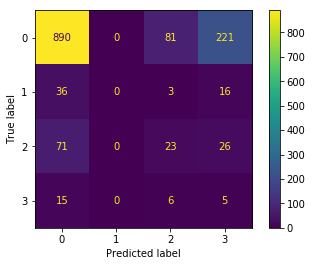

In [55]:
plot_confusion_matrix(lr_model, X, Y)

In [41]:
# classification report
print(classification_report(Y, Y_hat))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1192
           1       0.00      0.00      0.00        55
           2       0.20      0.19      0.20       120
           3       0.02      0.19      0.03        26

    accuracy                           0.66      1393
   macro avg       0.28      0.28      0.26      1393
weighted avg       0.77      0.66      0.71      1393



/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
# accuracy measure
print("Accuracy: ", accuracy_score(Y,Y_hat))

Accuracy:  0.6590093323761665


In [43]:
# kNN, k = 9
# Printing our our predicted values
Y_hat = knn_model.predict(X)
with np.printoptions(threshold=np.inf):
    print(Y_hat)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 0 3 0 2 0 3 0 3 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 2 0 0 3 2 0 0 3 3 2 3 0 3 2
 3 0 0 0 0 0 0 3 3 3 0 0 0 0 2 3 0 3 0 3 0 0 0 0 0 0 0 3 0 2 2 3 2 0 0 2 3
 0 0 0 0 0 0 0 0 0 2 0 2 3 0 0 3 0 0 3 3 0 3 0 0 0 0 3 0 3 3 3 0 3 0 0 0 3
 0 0 0 0 0 0 2 0 0 0 0 3 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 2 3 0
 0 0 0 0 0 3 2 0 2 0 0 0 0 0 0 3 2 0 0 0 0 0 0 0 0 3 0 0 2 0 3 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 3 0
 0 3 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 0 0 

In [44]:
# confusion matrix
conf_matrix = confusion_matrix(Y, Y_hat)
print(conf_matrix)

[[1035    3   73   81]
 [  45    0    1    9]
 [  84    0   11   25]
 [  11    0    5   10]]


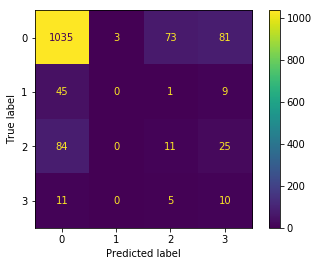

In [56]:
plot_confusion_matrix(knn_model, X, Y)

In [45]:
# classification report
print(classification_report(Y, Y_hat))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1192
           1       0.00      0.00      0.00        55
           2       0.12      0.09      0.10       120
           3       0.08      0.38      0.13        26

    accuracy                           0.76      1393
   macro avg       0.27      0.34      0.28      1393
weighted avg       0.77      0.76      0.76      1393



In [46]:
# accuracy measure
print("Accuracy: ", accuracy_score(Y,Y_hat))

Accuracy:  0.7580760947595119


In [47]:
# Classification tree
# Printing our our predicted values
Y_hat = tree_model.predict(X)
with np.printoptions(threshold=np.inf):
    print(Y_hat)

[0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 3 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 3 0 0 2 0 3 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 2 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 3 0 0 0 0 0 3 0 0 0 3 3 2 3 0 2 2 2 3 3 0 2
 0 0 0 3 3 0 0 0 0 3 0 2 0 2 3 3 0 2 0 2 0 3 3 3 3 0 3 2 0 2 2 2 2 0 0 2 2
 3 2 0 0 2 2 2 0 2 3 0 2 0 3 3 3 3 0 0 0 0 3 0 2 2 2 3 0 0 2 2 0 3 0 2 0 3
 3 0 0 3 2 0 0 3 0 3 3 0 3 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 2 0 0 3 0 2 3 0 2 1 0 0 3 0 3 0 0 0 0 0 3 3 2 0 0 0 2 3 3 0 0
 3 0 0 0 0 0 0 0 3 0 0 3 0 0 0 0 0 3 0 0 3 2 3 2 0 1 3 0 0 1 3 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 3 0 0 0 0 1
 0 3 3 0 0 2 0 3 0 0 0 3 0 1 0 3 3 0 3 3 0 0 3 0 0 2 1 1 0 0 3 0 3 0 3 1 0
 0 0 0 0 2 0 0 0 0 0 0 0 

In [48]:
# confusion matrix
conf_matrix = confusion_matrix(Y, Y_hat)
print(conf_matrix)

[[833  55  99 205]
 [ 21   6  13  15]
 [ 44   6  30  40]
 [ 10   0   9   7]]


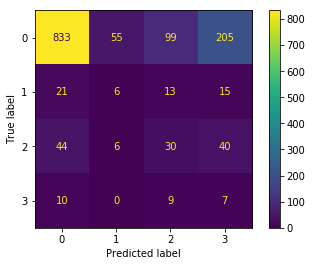

In [57]:
plot_confusion_matrix(tree_model, X, Y)

In [49]:
# classification report
print(classification_report(Y, Y_hat))

              precision    recall  f1-score   support

           0       0.92      0.70      0.79      1192
           1       0.09      0.11      0.10        55
           2       0.20      0.25      0.22       120
           3       0.03      0.27      0.05        26

    accuracy                           0.63      1393
   macro avg       0.31      0.33      0.29      1393
weighted avg       0.81      0.63      0.70      1393



In [50]:
# accuracy measure
print("Accuracy: ", accuracy_score(Y,Y_hat))

Accuracy:  0.6288585786073223


Looks like kNN performs best! We were able to predict the 2021 songs' groups with around 75% accuracy.